In [1]:
import urllib.request
url = "https://github.com/srg-lc/iddm/blob/main/data.zip?raw=true"
print ("download start!")
filename, headers = urllib.request.urlretrieve(url, filename="data.zip")
print ("download complete!")
print ("download file location: ", filename)

download start!
download complete!
download file location:  data.zip


In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')



In [3]:
print("Iniciando...")
print("Carregando dataset...")
dataset = pd.read_csv('data.zip', low_memory=False)




Iniciando...
Carregando dataset...


In [4]:
dataset['device_model'].unique()

array(['webcam.Samsung.SNH-1011N', 'laptop.Dell.Latitude_7400',
       'light_bulb.TP_Link.LB130', 'laptop.Dell.Latitude_E6430',
       'speaker.Sonos.One', 'doorbell.Amazon.Ring',
       'access_point.TP_Link.TL-WA901ND', 'webcam.Amcrest.IPM-721W',
       'smartphone.Samsung.Galaxy_Note_5', 'socket.Wemo.Insight',
       'smartphone.Samsung.Galaxy_Note_4',
       'streamer.Amazon.Fire_TV_Stick'], dtype=object)

In [5]:
#Filtrando Treino e predicao
data_training = dataset[dataset['partition'] == "training"]
dataset_t = data_training.copy()
data_training['partition'].unique()
data_predict = dataset[dataset['partition'] == "test"]
data_predict['partition'].unique()
dataset_p = data_predict.copy()


Fit e Transform devem ser aplicados apenas ao dataset de treino, no dataset de previsão, devo aplicar apenas o transform. Logo, fit e transform devem ser aplicados depois da separação de dados de treino e teste. 

In [6]:
from sklearn.preprocessing import LabelEncoder
number1 = LabelEncoder()
number = number1.fit(dataset['IPV4_DST_ADDR'])
data_training['IPV4_DST_ADDR'] = number.transform(data_training['IPV4_DST_ADDR'])
data_predict['IPV4_DST_ADDR'] = number1.transform(data_predict['IPV4_DST_ADDR'])
number = number.fit(dataset['device_model'])
data_training['device_model'] = number.transform(data_training['device_model'])
data_predict['device_model'] = number1.transform(data_predict['device_model'])
number = number.fit(dataset['IP'])
data_training['IP'] = number.transform(data_training['IP'])
data_predict['IP'] = number1.transform(data_predict['IP'])

In [7]:
data_training.head()

,FIRST_SWITCHED,IN_BYTES,IN_PKTS,IPV4_DST_ADDR,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,PROTOCOL,SRC_TOS,TCP_FLAGS,...,SRC_AS,DST_AS,INPUT_SNMP,OUTPUT_SNMP,IPV4_SRC_ADDR,MAC,category,type,date,inter_arrival_time
0,1.579047e+09,240.0,4.0,6999,5222.0,3696.0,1.579043e+09,6.0,0.0,2.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-01-15,1.579048e+09
1,1.579047e+09,76.0,1.0,1833,123.0,4039.0,1.579043e+09,17.0,0.0,0.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-01-15,2.100000e+01
2,1.579047e+09,120.0,2.0,7092,5222.0,3661.0,1.579043e+09,6.0,0.0,2.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-01-15,1.000000e+01
3,1.579047e+09,76.0,1.0,1490,123.0,4040.0,1.579043e+09,17.0,0.0,0.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-01-15,2.000000e+01
4,1.579047e+09,60.0,1.0,7092,5222.0,3661.0,1.579043e+09,6.0,0.0,2.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-01-15,1.000000e+00


In [8]:
data_predict.head()

,FIRST_SWITCHED,IN_BYTES,IN_PKTS,IPV4_DST_ADDR,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,PROTOCOL,SRC_TOS,TCP_FLAGS,...,SRC_AS,DST_AS,INPUT_SNMP,OUTPUT_SNMP,IPV4_SRC_ADDR,MAC,category,type,date,inter_arrival_time
171845,1.581638e+09,76.0,1.0,893,123.0,4242.0,1.581634e+09,17.0,0.0,0.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-02-14,24.0
171846,1.581638e+09,120.0,2.0,7092,5222.0,1655.0,1.581634e+09,6.0,0.0,2.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-02-14,6.0
171847,1.581638e+09,76.0,1.0,1798,123.0,4243.0,1.581634e+09,17.0,0.0,0.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-02-14,24.0
171848,1.581638e+09,120.0,2.0,6933,5222.0,4816.0,1.581634e+09,6.0,0.0,2.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-02-14,6.0
171849,1.581638e+09,60.0,1.0,6933,5222.0,4816.0,1.581634e+09,6.0,0.0,2.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-02-14,21.0


In [9]:
# Atribuindo features a dataset de treino
dataset_ft = pd.DataFrame()
dataset_ft['FIRST_SWITCHED'] = data_training['FIRST_SWITCHED'] # Feature 10
dataset_ft['IN_BYTES'] = data_training['IN_BYTES'] # Feature 12
dataset_ft['IN_PKTS'] = data_training['IN_PKTS'] # Feature 13
# dataset_ft['IPV4_DST_ADDR'] = data_training['IPV4_DST_ADDR'] # Feature 9
dataset_ft['L4_DST_PORT'] = data_training['L4_DST_PORT'] # Feature 0
dataset_ft['L4_SRC_PORT'] = data_training['L4_SRC_PORT'] # Feature 1
dataset_ft['SRC_TOS'] = data_training['SRC_TOS'] # Feature 2
dataset_ft['LAST_SWITCHED'] = data_training['LAST_SWITCHED'] # Feature 3 x
dataset_ft['PROTOCOL'] = data_training['PROTOCOL'] # Feature 8 x
dataset_ft['TCP_FLAGS'] = data_training['TCP_FLAGS'] # Feature 7 


In [10]:
# Atribuindo features a dataset de predicao
dataset_fp = pd.DataFrame()
dataset_fp['FIRST_SWITCHED'] = data_predict['FIRST_SWITCHED'] # Feature 10
dataset_fp['IN_BYTES'] = data_predict['IN_BYTES'] # Feature 12
dataset_fp['IN_PKTS'] = data_predict['IN_PKTS'] # Feature 13
# dataset_fp['IPV4_DST_ADDR'] = data_predict['IPV4_DST_ADDR'] # Feature 9
dataset_fp['L4_DST_PORT'] = data_predict['L4_DST_PORT'] # Feature 0
dataset_fp['L4_SRC_PORT'] = data_predict['L4_SRC_PORT'] # Feature 1
dataset_fp['SRC_TOS'] = data_predict['SRC_TOS'] # Feature 2
dataset_fp['LAST_SWITCHED'] = data_predict['LAST_SWITCHED'] # Feature 3 x
dataset_fp['PROTOCOL'] = data_predict['PROTOCOL'] # Feature 8 x
dataset_fp['TCP_FLAGS'] = data_predict['TCP_FLAGS'] # Feature 7 

In [11]:
# Atribuindo valores do dataset de treino
X_train = dataset_ft.iloc[:, :].values #Pegar valores até a coluna de device-model
Y_train = data_training.iloc[:, 12].values # coluna device model deve ser utilizada como rótulos

In [12]:
# Atribuindo valores do dataset de predicao
X_test = dataset_fp.iloc[:, :].values #Pegar valores até a coluna de device-model
Y_test = data_predict.iloc[:, 12].values # coluna device model deve ser utilizada como rótulo

Configurando parâmetros para treino...
Treinando...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Salvando modelo...


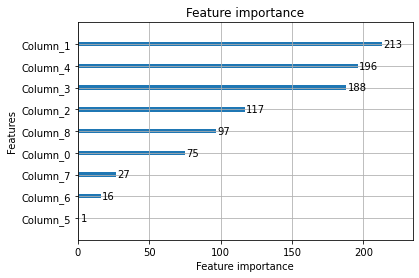

In [13]:
# Fase de treinamento
d_train = lgb.Dataset(X_train, label=Y_train)
print("Configurando parâmetros para treino...")
# params = {}
# params['num_leaves'] = 32 #definido no artigo
params = {
    'num_leaves': 32,
    'metric': ('l1', 'l2'),
    'verbose': 0
}
evals_result = {}  # to record eval results for plotting
#params['min_data'] = 50 # parametros não definidos no artigo, portanto, default
#params['max_depth'] = 10
print("Treinando...")
clf = lgb.train(params, d_train, 30) # max_iterations definido no artigo
lgb.plot_importance(clf)
print("Salvando modelo...")
clf.save_model('model.txt')

In [14]:
dataset_ft

,FIRST_SWITCHED,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,SRC_TOS,LAST_SWITCHED,PROTOCOL,TCP_FLAGS
0,1.579047e+09,240.0,4.0,5222.0,3696.0,0.0,1.579043e+09,6.0,2.0
1,1.579047e+09,76.0,1.0,123.0,4039.0,0.0,1.579043e+09,17.0,0.0
2,1.579047e+09,120.0,2.0,5222.0,3661.0,0.0,1.579043e+09,6.0,2.0
3,1.579047e+09,76.0,1.0,123.0,4040.0,0.0,1.579043e+09,17.0,0.0
4,1.579047e+09,60.0,1.0,5222.0,3661.0,0.0,1.579043e+09,6.0,2.0
...,...,...,...,...,...,...,...,...,...
1534662,1.581638e+09,86.0,1.0,443.0,48145.0,0.0,1.581634e+09,6.0,24.0
1534663,1.581638e+09,86.0,1.0,443.0,48145.0,0.0,1.581634e+09,6.0,24.0
1534664,1.581638e+09,86.0,1.0,443.0,48145.0,0.0,1.581634e+09,6.0,24.0
1534665,1.581638e+09,86.0,1.0,443.0,48145.0,0.0,1.581634e+09,6.0,24.0


In [15]:
# Testando treinamento
print("Preparando Predição...")
clf = lgb.Booster(model_file='model.txt')
ypred = clf.predict(X_test)
print(f'Resultado da predicao: {ypred}')
print(f'Rótulos (device_model): {Y_test}')
ypred = ypred.round(decimals=0, out=None)
accuracy = metrics.accuracy_score(Y_test, ypred)*100
print(f'Acerto do modelo: {round(accuracy,2)}%')

Preparando Predição...
Resultado da predicao: [ 8.99969175 10.85280521  8.99969175 ...  8.83086121  8.83086121
  8.83086121]
Rótulos (device_model): [11 11 11 ...  9  9  9]
Acerto do modelo: 78.67%


In [16]:
# Relatorio de metricas
print("Classification Report -----------------")
print(metrics.classification_report(Y_test, ypred))


Classification Report -----------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2505
         1.0       1.00      0.97      0.98      3156
         2.0       0.00      0.00      0.00       946
         3.0       0.00      0.00      0.00         0
         4.0       0.97      1.00      0.98     19520
         5.0       0.81      0.54      0.65     12490
         6.0       0.12      0.37      0.18      2429
         7.0       0.73      0.66      0.69     62867
         8.0       0.30      0.34      0.32     14832
         9.0       0.57      0.73      0.64     30619
        10.0       0.92      1.00      0.96     90709
        11.0       1.00      0.77      0.87     46054

    accuracy                           0.79    286127
   macro avg       0.53      0.53      0.52    286127
weighted avg       0.80      0.79      0.79    286127



In [17]:
ypred

array([ 9., 11.,  9., ...,  9.,  9.,  9.])

In [18]:
print(data_predict.device_model.value_counts(sort=False))
print("----------------------------")
print(dataset_p.device_model.value_counts(sort=False))

11    46054
2       946
4     19520
8     14832
1      3156
0      2505
10    90709
6      2429
7     62867
5     12490
9     30619
Name: device_model, dtype: int64
----------------------------
webcam.Samsung.SNH-1011N            46054
laptop.Dell.Latitude_7400             946
light_bulb.TP_Link.LB130            19520
speaker.Sonos.One                   14832
doorbell.Amazon.Ring                 3156
access_point.TP_Link.TL-WA901ND      2505
webcam.Amcrest.IPM-721W             90709
smartphone.Samsung.Galaxy_Note_5     2429
socket.Wemo.Insight                 62867
smartphone.Samsung.Galaxy_Note_4    12490
streamer.Amazon.Fire_TV_Stick       30619
Name: device_model, dtype: int64


In [19]:
print(data_training.device_model.value_counts(sort=False))
print("----------------------------")
print(dataset_t.device_model.value_counts(sort=False))

11    171845
2       3918
4      83247
3      23254
8      63648
1      14023
0      10708
10    388783
6      12572
7     276733
5      98760
9     131668
Name: device_model, dtype: int64
----------------------------
webcam.Samsung.SNH-1011N            171845
laptop.Dell.Latitude_7400             3918
light_bulb.TP_Link.LB130             83247
laptop.Dell.Latitude_E6430           23254
speaker.Sonos.One                    63648
doorbell.Amazon.Ring                 14023
access_point.TP_Link.TL-WA901ND      10708
webcam.Amcrest.IPM-721W             388783
smartphone.Samsung.Galaxy_Note_5     12572
socket.Wemo.Insight                 276733
smartphone.Samsung.Galaxy_Note_4     98760
streamer.Amazon.Fire_TV_Stick       131668
Name: device_model, dtype: int64


In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, ypred)
print("Confusion Matrix -----------------")
print(confusion_matrix(Y_test, ypred))

Confusion Matrix -----------------
[[    0     0     0     0     0     0   301  2201     0     0     0     3]
 [    0  3049     0     6    36    49     6     9     0     0     1     0]
 [    0     0     0    33   345   340   165    39    17     5     2     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0 19518     0     0     0     0     0     0     2]
 [    0     0     0     0   257  6730  4188  1261    50     3     0     1]
 [    0     0     0     0    38   916   904   346   210    14     1     0]
 [    0     0     0     0     0     0     0 41468  3278 14376  3745     0]
 [    0     0     0     0     1    16  1191  8549  5040     3     8    24]
 [    0     0     0     0    10   219   821  2367  4708 22493     0     1]
 [    0     0     0     0     0     0     2     2    50   358 90297     0]
 [    0     0     0     0     0     0     4   295  3505  2430  4230 35590]]
